In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Paths to the data
base_dir = '/content/drive/MyDrive/***DataSet_Thesis2024/new2024_3_Sobel/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [4]:
# Hyperparameters
img_size = 128
batch_size = 16
learning_rate = 0.001
num_epochs = 30

Epoch 1/30, Training Loss: 0.5108, Validation Loss: 0.3663, Training Accuracy: 0.7469, Validation Accuracy: 0.8406
Epoch 2/30, Training Loss: 0.3243, Validation Loss: 0.3014, Training Accuracy: 0.8725, Validation Accuracy: 0.8794
Epoch 3/30, Training Loss: 0.2410, Validation Loss: 0.3316, Training Accuracy: 0.9106, Validation Accuracy: 0.8381
Epoch 4/30, Training Loss: 0.2038, Validation Loss: 0.3387, Training Accuracy: 0.9225, Validation Accuracy: 0.8588
Epoch 5/30, Training Loss: 0.1425, Validation Loss: 0.3253, Training Accuracy: 0.9519, Validation Accuracy: 0.8838
Epoch 6/30, Training Loss: 0.1666, Validation Loss: 0.3199, Training Accuracy: 0.9413, Validation Accuracy: 0.8756
Epoch 7/30, Training Loss: 0.1327, Validation Loss: 0.3403, Training Accuracy: 0.9463, Validation Accuracy: 0.8719
Epoch 8/30, Training Loss: 0.1108, Validation Loss: 0.2931, Training Accuracy: 0.9613, Validation Accuracy: 0.9006
Epoch 9/30, Training Loss: 0.1018, Validation Loss: 0.3411, Training Accuracy: 0

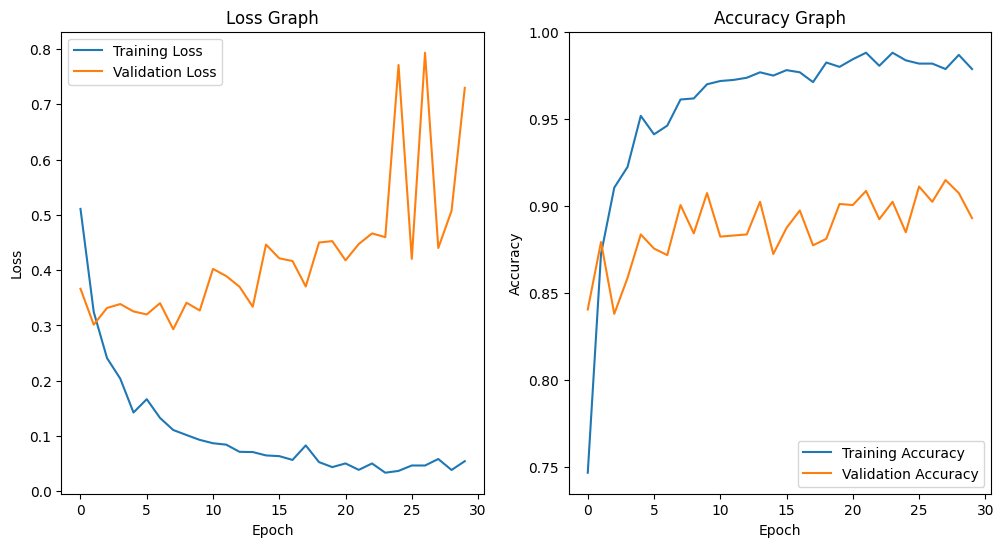

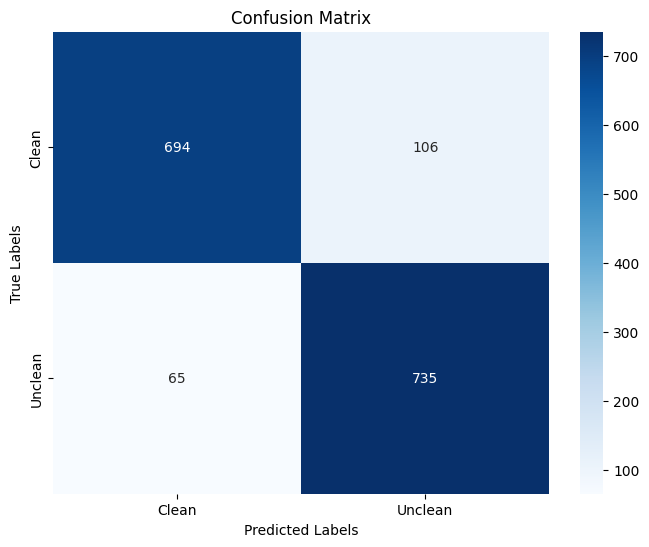

Classification Report:
               precision    recall  f1-score   support

       Clean       0.91      0.87      0.89       800
     Unclean       0.87      0.92      0.90       800

    accuracy                           0.89      1600
   macro avg       0.89      0.89      0.89      1600
weighted avg       0.89      0.89      0.89      1600



In [5]:
# Transformations for images
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define the MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_size):
        super(MLPClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = img_size * img_size * 3  # For RGB images
model = MLPClassifier(input_size=input_size).to(device)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and validation loop
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Calculate training accuracy
        preds = (outputs > 0.5).float()
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            preds = (outputs > 0.5).float()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
          f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Plot loss and accuracy graphs
plt.figure(figsize=(12, 6))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = (outputs > 0.5).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, np.array(all_preds).flatten())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report
print("Classification Report:\n", classification_report(all_labels, np.array(all_preds).flatten(), target_names=train_dataset.classes))
